# Project: Improving Disaster Resilience

## FEMA Disaster Forecast Analysis - Working Notebook

### 
### Data Science in Practice - Spring, 2023

### Data Used: DisastersDeclarationSummaries.csv 

Andrew Sommers

### Purpose

- Use ARIMA to forecast FEMA disaster events


#### History 🗓️

Date | Person | Details
---- | ------ | -------
04/02/2023| Andrew Sommers| Create initial notebook
04/28/2023| Andrew Sommers| Allow selection of the event ceategory for ARIMA forcasting




### Importing Libraries

We start by importing the libraries required for this notebook, adding in the ACS API key, and creating the function `json_to_dataframe` which is the function used in all our notebooks that make a call to the API. This function converts the API response into a dataframe and a readable format.

In [1]:
#import requests # request http, api
import pandas as pd # tabluar data
#from functools import reduce
import numpy as np
import os

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

# ARIMA
# https://towardsdatascience.com/introduction-to-arima-for-time-series-forecasting-ee0bc285807a
# https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None # show all columns in display
pd.options.display.max_rows = None # show all columns in display

In [14]:
# change the notebooks working directory to the Disaster Resilience Code Directory - change this for your local environment
# set the working directory where the 'Data' folder is located.  
# this notebook assumes data files are located in a 'Data' folder in the following path:
os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Code\\Data')

In [15]:
# load the FEMA Disasters DeclarationsHistory file 
# loading the disaster summry file suplied by Sahil
FEMA_History_County = pd.read_csv(f'FEMA_POP_GDP_ECO_METRO.csv')
len(FEMA_History_County)

60980

In [16]:
# Remove duplicates of disasters by 'declaration date'
# Sort the dataframe by year
FEMA_History_Unique = FEMA_History_County.drop_duplicates(subset = ['declarationDate'], keep = False)
FEMA_History_Unique = FEMA_History_Unique.sort_values(by=['fyDeclared'])
len(FEMA_History_Unique)
#FEMA_History_Unique.head(10)

674

In [17]:
# this cell will colsidate FEMA Incident Types to few categories.
# related types of Incidents are consolidated to an exist FEMA Incident Type
# the consolidation rules can be changed as necessary
# some Incident Types are dropped due to be rare and highly localized
# 
#  If the analysis will be run on the provided FEMA Incident Types, simply bypass this cell
#
target_mapping = {
    'Hurricane': 'Marine and Tropical Storm Events',
    'Coastal Storm': 'Marine and Tropical Storm Events',
    'Tropical Storm': 'Marine and Tropical Storm Events',
    'Typhoon': 'Marine and Tropical Storm Events',
    'Earthquake': 'Earthquake',
    'Biological': 'Biological',
    'Flood': 'Flood and Related Events',
    'Drought': 'Drought',
    'Fire': 'Fire and Related Events',
    'Winter Storm': 'Winter Storms and Related Events',
    'Freezing': 'Winter Storms and Related Events',
    'Severe Ice Storm': 'Winter Storms and Related Events',
    'Snowstorm': 'Winter Storms and Related Events',
    'Severe Storm': 'Severe Storms and Related Events',
    'Tornado': 'Severe Storms and Related Events',
    'Mud/Landslide': 'Severe Storms and Related Events',
    'Dam/Levee Break': 'Severe Storms and Related Events',
    'Human Cause': 'Human Caused Events',
    'Toxic Substances': 'Human Caused Events',
    'Fishing Losses': 'Human Caused Events',
    'Chemical': 'Human Caused Events',
    'Other': 'Other Events - Consolidated',
    'Terrorist': 'Other Events - Consolidated',
    'Volcanic Eruption': 'Other Events - Consolidated',
    'Tsunami': 'Other Events - Consolidated'
}
FEMA_History_Unique["incidentType"] = FEMA_History_Unique["incidentType"].map(lambda x: target_mapping[x])
# drop incident types classified as 'Other':  unique, non-reocurring or localized incidents
FEMA_History_Unique = FEMA_History_Unique[FEMA_History_Unique['incidentType'] != 'Other Events - Consolidated']
len(FEMA_History_Unique)
#FEMA_History_Unique.head(10)

663

In [13]:
# use pandas crosstab to generate a new dataframe of counts of disasters per year
# creates a simple moving average of the disasters - see the third line of code in this cell
dfDisasterCounts = pd.crosstab(FEMA_History_Unique.incidentType,FEMA_History_Unique.fyDeclared).stack().reset_index().rename(columns={0:'Count'})
dfDisasterCounts = dfDisasterCounts.sort_values(by=['fyDeclared'])
dfDisasterCounts['Count'] = dfDisasterCounts['Count'].fillna(0)
#dfDisasterCounts['Years'] = pd.to_datetime(dfDisasterCounts['fyDeclared'], format = '%Y')
dfDisasterCounts.rename(columns = {"fyDeclared":"Years"}, inplace = True)
dfDisastersPivot = dfDisasterCounts.pivot(index = 'Years', columns = 'incidentType', values = 'Count')
#dfDisastersPivot.index = pd.DatetimeIndex(dfDisastersPivot.index).to_period('Y')
dfDisastersPivot.tail(5)

incidentType,Drought,Earthquake,Fire and Related Events,Flood and Related Events,Human Caused Events,Marine and Tropical Storm Events,Severe Storms and Related Events,Winter Storms and Related Events
Years,,,,,,,,
2019,0,0,11,1,0,1,2,0
2020,0,0,23,0,0,0,0,0
2021,0,0,23,1,0,0,0,0
2022,0,0,21,1,0,1,3,0
2023,0,0,1,1,0,0,0,0


### This section applies the ARIMA model to the selected FEMA disaster event category
- The parameters for the ARIMA model can be set below
- Select the event category to forecast in the next cell

In [91]:
# select the event category for forecasting
specified_event = 'Marine and Tropical Storm Events'
#specified_event = 'Severe Storms and Related Events' # specify the event of interest
#specified_event = 'Flood and Related Events'
#specified_event = 'Fire and Related Events'
#specified_event = 'Winter Storms and Related Events'
#specified_event = 'Earthquake'
#specified_event = 'Drought'
#specified_event = 'Human Caused Events'
#specified_event = 'Biological'

dfSpecificDisasters = pd.DataFrame(dfDisastersPivot[specified_event])
dfSpecificDisasters.rename(columns = {specified_event:"Count"}, inplace = True)
dfSpecificDisasters.index = pd.to_datetime(dfSpecificDisasters.index, format = '%Y')
dfSpecificDisasters.sort_index(inplace = True)
dfSpecificDisasters.tail(5)

,Count
Years,
2019-01-01,1
2020-01-01,0
2021-01-01,0
2022-01-01,1
2023-01-01,0


In [92]:
# Use the Augmented Dickey-Fuller statistic to test for data stability
# if the ADF statistic is within the critical value range, the data is sufficiently stable. 
result = adfuller(dfSpecificDisasters['Count'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.541667497083328
p-value: 1.6962097304977076e-06
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [93]:
# ARIMA model
# https://www.justintodata.com/arima-models-in-python-time-series-prediction/
# set parameters for p, d, q in the next line of code
model = ARIMA(dfSpecificDisasters, order = (1,0,7))
results = model.fit()
forecast = results.forecast(steps=10)
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   56
Model:                 ARIMA(1, 0, 7)   Log Likelihood                 -62.843
Date:                Fri, 28 Apr 2023   AIC                            145.685
Time:                        17:21:13   BIC                            165.939
Sample:                             0   HQIC                           153.537
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5557      0.218      2.543      0.011       0.127       0.984
ar.L1          0.0758      0.494      0.153      0.878      -0.892       1.044
ma.L1          0.1708      8.896      0.019      0.9

In [94]:
dfForecast = pd.DataFrame(results.fittedvalues)
dfForecast.rename(columns = {0: 'Count'}, inplace = True)
#
year_range = [2024, 2025, 2026, 2027, 2028]
df1 = pd.DataFrame(year_range)
df1.rename(columns = {0:"Years"}, inplace = True)
df1 = pd.to_datetime(df1['Years'], format = '%Y')  
df1= pd.DataFrame(df1)
#
df2 = pd.DataFrame(results.forecast(5)) # generates forecasted values from the model for number of periods set in the parameter
df2 = pd.DataFrame(df2['predicted_mean'])
df2.rename(columns = {"predicted_mean":"Count"}, inplace = True)
df2.index = np.arange(0, len(df2), +1)
#
df1 = df1.join(df2)
df1.set_index("Years", inplace = True)
dfForecast = pd.concat([dfForecast, df1])

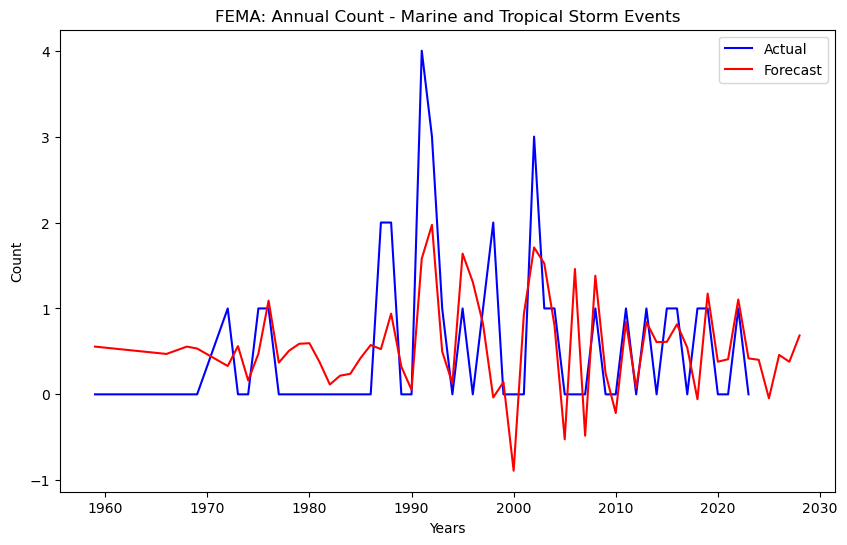

In [95]:
# plot the ARIMA forecasted data for the specified event
plt.figure(figsize=(10,6))
plt.plot(dfSpecificDisasters, color='blue', label = 'Actual')
plt.plot(dfForecast, color='red', label = 'Forecast')
plt.title("FEMA: Annual Count - " + specified_event)
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend() 
 